In [1]:
import time, math, random, bisect, copy
import gym
import numpy as np

In [2]:
class NeuralNet : 
    def __init__(self, nodeCount):     
        self.fitness = 0.0
        self.nodeCount = nodeCount
        self.weights = []
        self.biases = []
        for i in range(len(nodeCount) - 1):
            self.weights.append( np.random.uniform(low=-1, high=1, size=(nodeCount[i], nodeCount[i+1])).tolist() )
            self.biases.append( np.random.uniform(low=-1, high=1, size=(nodeCount[i+1])).tolist())


    def printWeightsandBiases(self):
        
        print("--------------------------------")
        print("Weights :\n[", end="")
        for i in range(len(self.weights)):
            print("\n [ ", end="")
            for j in range(len(self.weights[i])):
                if j!=0:
                    print("\n   ", end="")
                print("[", end="")
                for k in range(len(self.weights[i][j])):
                    print(" %5.2f," % (self.weights[i][j][k]), end="")
                print("\b],", end="")
            print("\b ],")
        print("\n]")

        print("\nBiases :\n[", end="")
        for i in range(len(self.biases)):
            print("\n [ ", end="")
            for j in range(len(self.biases[i])):
                    print(" %5.2f," % (self.biases[i][j]), end="")
            print("\b],", end="")
        print("\b \n]\n--------------------------------\n")
  
    def getOutput(self, input):
        output = input
        for i in range(len(self.nodeCount)-1):
            output = np.reshape( np.matmul(output, self.weights[i]) + self.biases[i], (self.nodeCount[i+1]))
        return np.argmax(output)



In [3]:
class Population :
    def __init__(self, populationCount, mutationRate, nodeCount):
        self.nodeCount = nodeCount
        self.popCount = populationCount
        self.m_rate = mutationRate
        self.population = [ NeuralNet(nodeCount) for i in range(populationCount)]


    def createChild(self, nn1, nn2):
        
        child = NeuralNet(self.nodeCount)
        for i in range(len(child.weights)):
            for j in range(len(child.weights[i])):
                for k in range(len(child.weights[i][j])):
                    if random.random() > self.m_rate:
                        if random.random() < nn1.fitness / (nn1.fitness+nn2.fitness):
                            child.weights[i][j][k] = nn1.weights[i][j][k]
                        else :
                            child.weights[i][j][k] = nn2.weights[i][j][k]
                        

        for i in range(len(child.biases)):
            for j in range(len(child.biases[i])):
                if random.random() > self.m_rate:
                    if random.random() < nn1.fitness / (nn1.fitness+nn2.fitness):
                        child.biases[i][j] = nn1.biases[i][j]
                    else:
                        child.biases[i][j] = nn2.biases[i][j]

        return child


    def createNewGeneration(self, bestNN):    

        nextGen = []
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        for i in range(self.popCount):
            if random.random() < float(self.popCount-i)/self.popCount:
                nextGen.append(copy.deepcopy(self.population[i]));

        fitnessSum = [0]
        minFit = min([i.fitness for i in nextGen])
        for i in range(len(nextGen)):
            fitnessSum.append(fitnessSum[i]+(nextGen[i].fitness-minFit)**4)
        

        while(len(nextGen) < self.popCount):
            r1 = random.uniform(0, fitnessSum[len(fitnessSum)-1] )
            r2 = random.uniform(0, fitnessSum[len(fitnessSum)-1] )
            nn1 = nextGen[bisect.bisect_right(fitnessSum, r1)-1]
            nn2 = nextGen[bisect.bisect_right(fitnessSum, r2)-1]
            nextGen.append( self.createChild(nn1, nn2) )
        self.population.clear()
        self.population = nextGen


In [4]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def replayBestBots(bestNeuralNets, steps, sleep):  
    for i in range(len(bestNeuralNets)):
        if i%steps == 0 :
            observation = env.reset()
            print("Generation %3d had a best fitness of %4d" % (i, bestNeuralNets[i].fitness))
            for step in range(MAX_STEPS):
                env.render()
                time.sleep(sleep)
                action = bestNeuralNets[i].getOutput(observation)
                observation, reward, done, info = env.step(action)
                if done:
                    observation = env.reset()
                    break
            print("Steps taken =", step)


def mapRange(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.

    return rightMin + (valueScaled * rightSpan)

def normalizeArray(aVal, aMin, aMax): 
    res = []
    for i in range(len(aVal)):
        res.append( mapRange(aVal[i], aMin[i], aMax[i], -1, 1) )
    return res

def scaleArray(aVal, aMin, aMax):   
    res = []
    for i in range(len(aVal)):
        res.append( mapRange(aVal[i], -1, 1, aMin[i], aMax[i]) )
    return res


In [13]:
GAME = 'LunarLander-v2'
MAX_STEPS = 200
MAX_GENERATIONS = 500
POPULATION_COUNT = 100
MUTATION_RATE = 0.002

env = gym.make(GAME)
#env.monitor.start('NNGA/'+GAME, force=True, video_callable=RECORD )
observation = env.reset()
in_dimen = env.observation_space.shape[0]
    out_dimen = env.action_space.n
obsMin = env.observation_space.low
obsMax = env.observation_space.high
actionMin = 0
actionMax = env.action_space.n
pop = Population(POPULATION_COUNT, MUTATION_RATE, [in_dimen, 10, 10, out_dimen])
bestNeuralNets = []

print("\nObservation\n--------------------------------")
print("Shape :", in_dimen, " | High :", obsMax, " | Low :", obsMin)
print("\nAction\n--------------------------------")
print("Shape :", out_dimen, " | High :", actionMax, " | Low :", actionMin,"\n")

plotGen = []
plotGenAvgFit = []
plotMaxFit = []
for gen in range(MAX_GENERATIONS):
    genAvgFit = 0.0
    maxFit = -100000000
    maxNeuralNet = None
    for nn in pop.population:
        totalReward = 0
        for step in range(MAX_STEPS):
            #env.render()
            action = nn.getOutput(observation)
            observation, reward, done, info = env.step(action)
            totalReward += reward
            if done:
                observation = env.reset()
                break

        nn.fitness = totalReward
        genAvgFit += nn.fitness
        if nn.fitness > maxFit :
            maxFit = nn.fitness
            maxNeuralNet = copy.deepcopy(nn);

    bestNeuralNets.append(maxNeuralNet)
    genAvgFit/=pop.popCount
    print("Generation : %3d |  Avg Fitness : %5.0f  |  Max Fitness : %5.0f  " % (gen+1, genAvgFit, maxFit) )
    plotGen.append(gen+1)
    plotGenAvgFit.append(genAvgFit)
    plotMaxFit.append(maxFit)
    pop.createNewGeneration(maxNeuralNet)




Observation
--------------------------------
Shape : 8  | High : [inf inf inf inf inf inf inf inf]  | Low : [-inf -inf -inf -inf -inf -inf -inf -inf]

Action
--------------------------------
Shape : 4  | High : 4  | Low : 0 

Generation :   1 |  Avg Fitness :  -464  |  Max Fitness :     9  
Generation :   2 |  Avg Fitness :  -392  |  Max Fitness :     0  
Generation :   3 |  Avg Fitness :  -328  |  Max Fitness :     7  
Generation :   4 |  Avg Fitness :  -275  |  Max Fitness :    65  
Generation :   5 |  Avg Fitness :  -300  |  Max Fitness :   141  
Generation :   6 |  Avg Fitness :  -290  |  Max Fitness :    90  
Generation :   7 |  Avg Fitness :  -219  |  Max Fitness :    98  
Generation :   8 |  Avg Fitness :  -130  |  Max Fitness :   156  
Generation :   9 |  Avg Fitness :  -104  |  Max Fitness :   135  
Generation :  10 |  Avg Fitness :   -47  |  Max Fitness :   156  
Generation :  11 |  Avg Fitness :   -36  |  Max Fitness :   133  
Generation :  12 |  Avg Fitness :   -17  |  Max

Generation : 122 |  Avg Fitness :    66  |  Max Fitness :   310  
Generation : 123 |  Avg Fitness :    62  |  Max Fitness :   285  
Generation : 124 |  Avg Fitness :    75  |  Max Fitness :   286  
Generation : 125 |  Avg Fitness :    63  |  Max Fitness :   270  
Generation : 126 |  Avg Fitness :    66  |  Max Fitness :   299  
Generation : 127 |  Avg Fitness :    89  |  Max Fitness :   313  
Generation : 128 |  Avg Fitness :    92  |  Max Fitness :   299  
Generation : 129 |  Avg Fitness :    85  |  Max Fitness :   297  
Generation : 130 |  Avg Fitness :    65  |  Max Fitness :   300  
Generation : 131 |  Avg Fitness :    71  |  Max Fitness :   292  
Generation : 132 |  Avg Fitness :    55  |  Max Fitness :   296  
Generation : 133 |  Avg Fitness :    79  |  Max Fitness :   289  
Generation : 134 |  Avg Fitness :    77  |  Max Fitness :   291  
Generation : 135 |  Avg Fitness :    76  |  Max Fitness :   292  
Generation : 136 |  Avg Fitness :    77  |  Max Fitness :   298  
Generation

Generation : 247 |  Avg Fitness :    78  |  Max Fitness :   291  
Generation : 248 |  Avg Fitness :    84  |  Max Fitness :   297  
Generation : 249 |  Avg Fitness :    54  |  Max Fitness :   278  
Generation : 250 |  Avg Fitness :    94  |  Max Fitness :   295  
Generation : 251 |  Avg Fitness :    83  |  Max Fitness :   296  
Generation : 252 |  Avg Fitness :    77  |  Max Fitness :   304  
Generation : 253 |  Avg Fitness :    84  |  Max Fitness :   283  
Generation : 254 |  Avg Fitness :   101  |  Max Fitness :   307  
Generation : 255 |  Avg Fitness :    80  |  Max Fitness :   291  
Generation : 256 |  Avg Fitness :    76  |  Max Fitness :   302  
Generation : 257 |  Avg Fitness :    97  |  Max Fitness :   295  
Generation : 258 |  Avg Fitness :    99  |  Max Fitness :   298  
Generation : 259 |  Avg Fitness :    79  |  Max Fitness :   290  
Generation : 260 |  Avg Fitness :    69  |  Max Fitness :   274  
Generation : 261 |  Avg Fitness :    98  |  Max Fitness :   294  
Generation

Generation : 372 |  Avg Fitness :    92  |  Max Fitness :   283  
Generation : 373 |  Avg Fitness :    89  |  Max Fitness :   299  
Generation : 374 |  Avg Fitness :    87  |  Max Fitness :   313  
Generation : 375 |  Avg Fitness :    72  |  Max Fitness :   287  
Generation : 376 |  Avg Fitness :    97  |  Max Fitness :   303  
Generation : 377 |  Avg Fitness :    92  |  Max Fitness :   299  
Generation : 378 |  Avg Fitness :    89  |  Max Fitness :   276  
Generation : 379 |  Avg Fitness :   114  |  Max Fitness :   291  
Generation : 380 |  Avg Fitness :   107  |  Max Fitness :   285  
Generation : 381 |  Avg Fitness :    83  |  Max Fitness :   312  
Generation : 382 |  Avg Fitness :    79  |  Max Fitness :   290  
Generation : 383 |  Avg Fitness :    94  |  Max Fitness :   317  
Generation : 384 |  Avg Fitness :   103  |  Max Fitness :   299  
Generation : 385 |  Avg Fitness :   119  |  Max Fitness :   306  
Generation : 386 |  Avg Fitness :    71  |  Max Fitness :   290  
Generation

Generation : 497 |  Avg Fitness :   106  |  Max Fitness :   307  
Generation : 498 |  Avg Fitness :   107  |  Max Fitness :   298  
Generation : 499 |  Avg Fitness :    86  |  Max Fitness :   284  
Generation : 500 |  Avg Fitness :   103  |  Max Fitness :   280  


AttributeError: 'LunarLander' object has no attribute 'monitor'

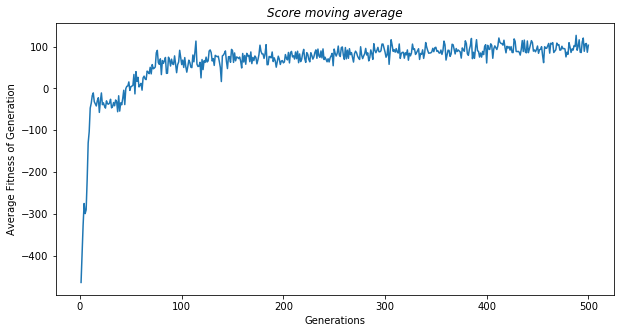

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.xlabel('Generations')
plt.ylabel('Average Fitness of Generation')
plt.title('Score moving average', fontstyle='italic')
plt.plot(plotGen[:500],plotGenAvgFit[:500])
plt.savefig('NNGA_1.pdf')  
plt.show()